# Haystack Building Blocks

## Installing Haystack

Install Haystack and other required packages with `pip`:

In [1]:
%%bash

pip install haystack-ai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.2/419.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00


In [2]:
!pip install trafilatura

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 837.8/837.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2


In [49]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.generators.chat import AzureOpenAIChatGenerator

from google.colab import userdata
from haystack.utils import Secret
from haystack.dataclasses import ChatMessage
from haystack.components.builders import ChatPromptBuilder

from haystack.components.embedders import AzureOpenAIDocumentEmbedder

from haystack.components.generators.chat import AzureOpenAIChatGenerator
from haystack.components.embedders import AzureOpenAITextEmbedder


In [50]:
embedder = AzureOpenAIDocumentEmbedder(
                              azure_endpoint = userdata.get("ada_end_point"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "text-embedding-ada-002"

)

In [51]:
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher

In [52]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

In [53]:
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()

In [54]:
from haystack.components.writers import DocumentWriter

In [55]:
writer = DocumentWriter(document_store=document_store)

In [56]:
from haystack import Pipeline

## fetcher --> converter --> embeddings -->writer

In [57]:
indexing = Pipeline()

indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)


indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)


In [58]:
indexing.connect("fetcher.streams", "converter.sources")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: AzureOpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])

In [59]:
indexing.connect("converter", "embedder")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: AzureOpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])

In [60]:
indexing.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: AzureOpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

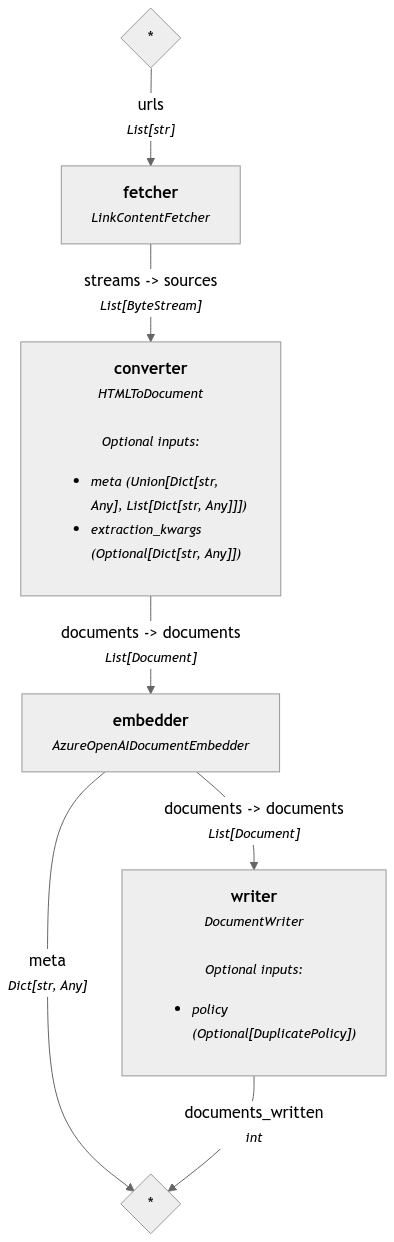

In [61]:
indexing.show()

In [62]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Embedding Texts: 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 5668, 'total_tokens': 5668}}},
 'writer': {'documents_written': 4}}

In [63]:
document_store.filter_documents()[0]

Document(id=e702fd349c9d5dbb355d2554bc03fd9bc867294c5a810c201dae29fc631eb7f7, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Haystack 2.0
You can use Coher...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere'}, embedding: vector of size 1536)

In [64]:
prompt = [
    ChatMessage.from_user(
        """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }}
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""
    )
]

prompt_builder = ChatPromptBuilder(template=prompt)

In [42]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

In [65]:
query_embedder = AzureOpenAITextEmbedder(azure_endpoint = userdata.get("ada_end_point"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "text-embedding-ada-002")

retriever = InMemoryEmbeddingRetriever(document_store = document_store)

prompt_builder = ChatPromptBuilder(template = prompt)

In [66]:
generator = AzureOpenAIChatGenerator(azure_endpoint = userdata.get("azure_endpoint"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "gpt-35-turbo")

In [67]:
rag = Pipeline()

rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

query_embedding --> retriever --> prompt --> generator

In [68]:
rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: AzureOpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: ChatPromptBuilder
  - generator: AzureOpenAIChatGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.messages (List[ChatMessage])

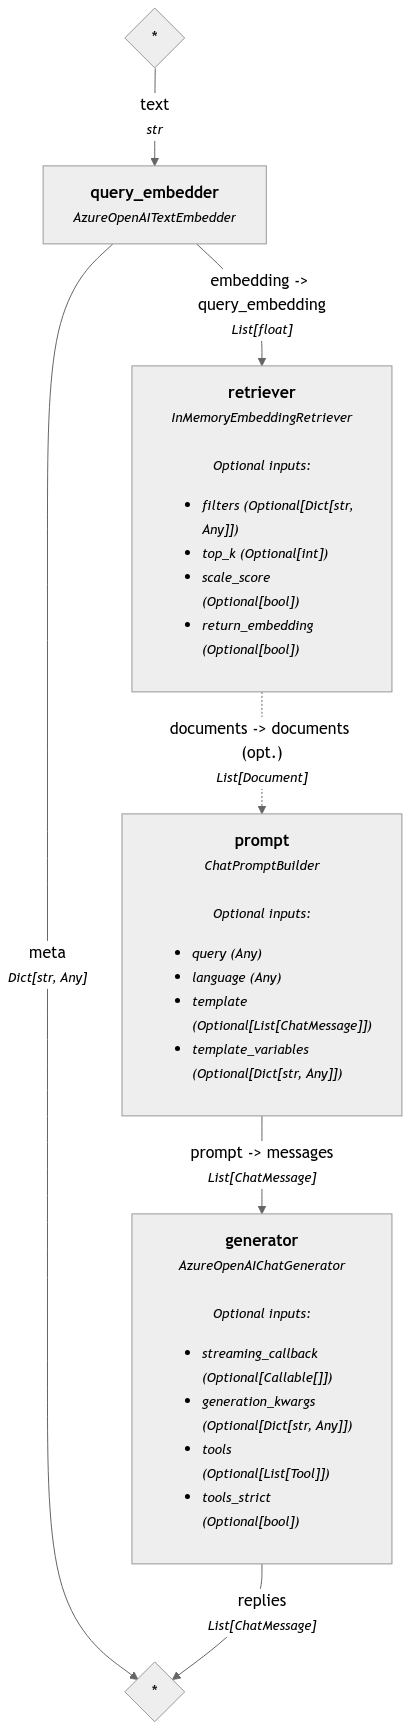

In [69]:
rag.show()

In [73]:
question = "How can I integrate Cohere with Haystack"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "English"}
    }
)

In [74]:
result

{'query_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 9, 'total_tokens': 9}}},
 'generator': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='You can use Cohere models with Haystack by installing the cohere-haystack package via pip. You can then use various components to integrate Cohere models into your pipelines, including CohereTextEmbedder and CohereDocumentEmbedder for embedding models, CohereGenerator for generative models, and CohereRanker for ranker models. More specifics on installation and usage can be found at the provided URL.')], _name=None, _meta={'model': 'gpt-35-turbo', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 84, 'prompt_tokens': 2093, 'total_tokens': 2177, 'completion_tokens_details': None, 'prompt_tokens_details': None}})]}}

In [75]:
question = "How all anthropic models I can use with Haystack"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "English"}
    }
)

In [76]:
result

{'query_embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 11, 'total_tokens': 11}}},
 'generator': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text='You can use Anthropic Claude models with Haystack. Currently available models are claude-2.1, claude-3-haiku-20240307, claude-3-sonnet-20240229, and claude-3-opus-20240229. To learn more about using Anthropic models with Haystack, including installation and usage instructions, please visit the following URL: https://haystack.deepset.ai/integrations/anthropic')], _name=None, _meta={'model': 'gpt-35-turbo', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 95, 'prompt_tokens': 1181, 'total_tokens': 1276, 'completion_tokens_details': None, 'prompt_tokens_details': None}})]}}

In [104]:
from haystack import component

In [105]:
@component
class Greeter:

  @component.output_types(greeting = str)
  def run(self, user_name: str):
    return {"greeting": f"Hello {user_name}"}

In [106]:
greeter = Greeter()

greeter.run(user_name= "Sarvesh")

{'greeting': 'Hello Sarvesh'}

In [107]:
prompt = [
    ChatMessage.from_user(""" You will be given the beginning of a dialogue.
Create a short play script using this as the start of the play. Start with greetings.
Start of dialogue: {{ dialogue }}
Full Script:
"""
    )
]

prompt_builder = ChatPromptBuilder(template=prompt)

In [108]:
llm = AzureOpenAIChatGenerator(azure_endpoint = userdata.get("azure_endpoint"),
                             api_key = Secret.from_token(userdata.get("api_key")),
                             azure_deployment = "gpt-35-turbo")

In [109]:
dialogue_builder = Pipeline()

dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt_builder)
dialogue_builder.add_component("llm", llm)

In [110]:
dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: ChatPromptBuilder
  - llm: AzureOpenAIChatGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.messages (List[ChatMessage])

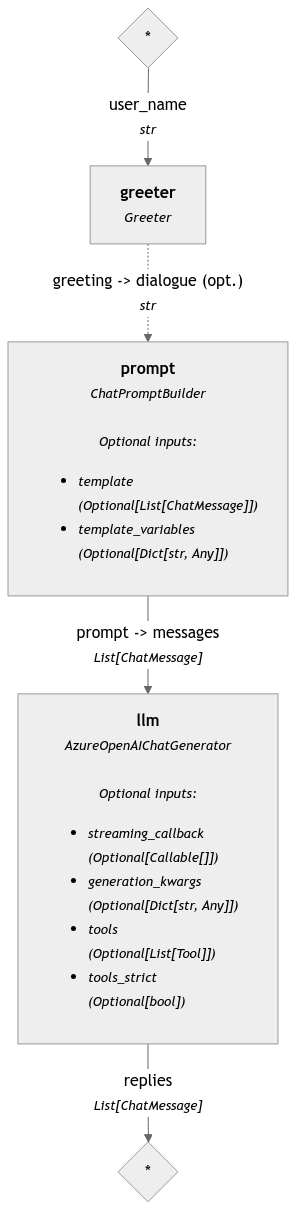

In [111]:
dialogue_builder.show()

In [112]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Sarvesh"}})

In [113]:
dialogue

{'llm': {'replies': [ChatMessage(_role=<ChatRole.ASSISTANT: 'assistant'>, _content=[TextContent(text="Scene: A living room\n\n(Enter Rhea)\n\nRhea: Hello Sarvesh! How are you doing today?\n\nSarvesh: I'm good, thank you. How about you?\n\nRhea: I'm doing fine too. I brought you some sweets, have a look.\n\nSarvesh: Oh, that's so sweet of you! Thank you.\n\nRhea: How's your work going on?\n\nSarvesh: It's been hectic lately. I have been working round the clock on this project.\n\nRhea: I can relate to that. My workload has increased too. But it's always good to have something to keep you occupied, right?\n\nSarvesh: Yeah! But sometimes it seems like there's no end to work.\n\nRhea: (laughs) I know what you mean. But hey, let's not talk about work all day. How about we plan something fun this weekend?\n\nSarvesh: That sounds great! What do you have in mind?\n\nRhea: How about we go on a long drive? We can explore some new places and take a break from our work routines.\n\nSarvesh: Yes, t